In [ ]:
# load packages 
%matplotlib inline
import os
import glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import geopandas as gpd
import pyproj
import shapely.geometry
from shapely.geometry import Point
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
import numpy as np
import xarray as xr
import rioxarray as rxr
from geocube.api.core import make_geocube
import xesmf as xe
import cartopy.crs as ccrs
import contextily as ctx
from scipy import stats

# imports for rasterizing 
import geopandas as gpd
import rasterio
from rasterio import features
from rasterio.enums import MergeAlg
from rasterio.plot import show
import xwrf

# dask
import dask
from dask.distributed import Client, LocalCluster

In [ ]:
# pre-define labels for easy re-use
# \mathrm{} prevents exprsesion from getting italicized 
# \/ within the latex expression is necessary for an empty space
degree_sign = u'\N{DEGREE SIGN}'
del_ta_label = r'$\mathrm{{\Delta}T_{2m}}$ (' + degree_sign + 'C)'
del_tc_label = r'$\mathrm{{\Delta}T_{c}}$ (' + degree_sign + 'C)'
ahf_label = r'Anthropogenic heat flux ($\mathrm{W\/m^{-2}}$)'
ws_label = r'$\mathrm{{\Delta}}$WS ($\mathrm{m\/s^{-1}}$)'
pblh_label = r'$\mathrm{{\Delta}}$PBLH (m)'

# color shortcutes
max_red = '#DD1717'  # red
yale_blue = '#0F4392'  # blue
brighter_blue = "#4DA6FF"
cyan = '#00FFFF'
orange = '#FF8C00'

# where to save plots
plot_dir ='/home1/kojoseph/ah-la-paper/figs/figs-for-kelly'
os.makedirs(plot_dir, exist_ok=True)

# AHF Heatmap

In [4]:
home_path = Path('/home1/kojoseph/anthropogenic-heat-la-20230205')
data_path = home_path / 'data'
output_path = data_path / 'output'
diurnal_path = output_path / '20231124/diurnal/08/weekday'
ahf_t = gpd.read_feather(diurnal_path / 'ahf_diurnal_control_traffic.feather')
ahf_b = gpd.read_feather(diurnal_path / 'ahf_diurnal_control_building.feather')
ahf_m = gpd.read_feather(diurnal_path / 'ahf_diurnal_control_metabolism.feather')

In [5]:
filename = 'ahf_diurnal_control_all.feather'
file_path = output_path / '20231124/diurnal/08/weekday' / filename
ahf_all = gpd.read_feather(file_path)

In [6]:
# create daily avg AHF dataframe
ahf_dict = {'t':ahf_t, 'b':ahf_b, 'm':ahf_m}
ahf_avg_dict = {}
for key in ahf_dict:
    df = ahf_dict[key]
    ahf_avg_dict[key] = df.iloc[:, -24:].mean(axis=1)
    
ahf_avg = ahf_t[['FID', 'geometry']].copy()
for key in ahf_avg_dict:
    column_label = 'ahf_' + key
    ahf_avg.insert(len(ahf_avg.columns), column_label, ahf_avg_dict[key])
ahf_avg['ahf_tot'] = ahf_avg['ahf_t'] + ahf_avg['ahf_b'] + ahf_avg['ahf_m']
ahf_avg.head()

FID                                           geometry  ahf_t  ahf_b  \
0  832323  POLYGON ((-118.45759 33.95103, -118.45759 33.9...    0.0    0.0   
1  832324  POLYGON ((-118.45761 33.95103, -118.45807 33.9...    0.0    0.0   
2  832325  POLYGON ((-118.45807 33.95177, -118.45849 33.9...    0.0    0.0   
3  830804  POLYGON ((-118.45849 33.95252, -118.45849 33.9...    0.0    0.0   
4  830805  POLYGON ((-118.45853 33.95252, -118.45899 33.9...    0.0    0.0   

   ahf_m  ahf_tot  
0    0.0      0.0  
1    0.0      0.0  
2    0.0      0.0  
3    0.0      0.0  
4    0.0      0.0

In [7]:
# create daily maximum (hr 13) ahf dataframe
ahf_val_dict = {}
for key, df in ahf_dict.items():
    ahf_val_dict[key] = df['ahf_13']   # pick the single column

# Build new GeoDataFrame with FID + geometry
ahf_max = ahf_t[['FID', 'geometry']].copy()

# Insert the selected ahf_13 values
for key in ahf_val_dict:
    column_label = 'ahf_' + key
    ahf_max.insert(len(ahf_max.columns), column_label, ahf_val_dict[key])

# Compute total
ahf_max['ahf_tot'] = ahf_max['ahf_t'] + ahf_max['ahf_b'] + ahf_max['ahf_m']

ahf_max.head()

FID                                           geometry  ahf_t  ahf_b  \
0  832323  POLYGON ((-118.45759 33.95103, -118.45759 33.9...    0.0    0.0   
1  832324  POLYGON ((-118.45761 33.95103, -118.45807 33.9...    0.0    0.0   
2  832325  POLYGON ((-118.45807 33.95177, -118.45849 33.9...    0.0    0.0   
3  830804  POLYGON ((-118.45849 33.95252, -118.45849 33.9...    0.0    0.0   
4  830805  POLYGON ((-118.45853 33.95252, -118.45899 33.9...    0.0    0.0   

   ahf_m  ahf_tot  
0    0.0      0.0  
1    0.0      0.0  
2    0.0      0.0  
3    0.0      0.0  
4    0.0      0.0

In [8]:
gdf_m = ahf_max.to_crs(epsg=32611)  # project to meters (important!)
# Choose your target resolution (50 meters)
resolution = 100

# Floor coordinates to nearest multiple of 50 m
gdf_m["x"] = (gdf_m.geometry.centroid.x // resolution) * resolution
gdf_m["y"] = (gdf_m.geometry.centroid.y // resolution) * resolution
len(gdf_m['x'].unique())

1211

In [11]:
# Rasterize into xarray dataset
import numpy as np
import xarray as xr
import geopandas as gpd

# Assume gdf is your large GeoDataFrame
gdf_m = ahf_max.to_crs(epsg=32611)  # project to meters (important!)

# Choose your target resolution (50 meters)
resolution = 100

# Floor coordinates to nearest multiple of 50 m
gdf_m["x"] = (gdf_m.geometry.centroid.x // resolution) * resolution
gdf_m["y"] = (gdf_m.geometry.centroid.y // resolution) * resolution

# Find unique sorted coordinates
x_coords = np.sort(gdf_m["x"].unique())
y_coords = np.sort(gdf_m["y"].unique())[::-1]  # descending so north at top

nx = len(x_coords)
ny = len(y_coords)

# build mapping from coordinate value -> array index
x_index = {x: i for i, x in enumerate(x_coords)}
y_index = {y: i for i, y in enumerate(y_coords)}

# Convert x/y to index arrays (vectorized)
x_idx = gdf_m["x"].map(x_index).to_numpy()
y_idx = gdf_m["y"].map(y_index).to_numpy()

# Build data variables
data_vars = {}
for col in ["ahf_t", "ahf_b", "ahf_m", "ahf_tot"]:
    arr = np.full((ny, nx), np.nan, dtype="float32")
    arr[y_idx, x_idx] = gdf_m[col].to_numpy()
    data_vars[col] = (("y", "x"), arr)

# Build xarray Dataset
ds = xr.Dataset(
    data_vars=data_vars,
    coords={"x": x_coords, "y": y_coords},
    attrs={"crs": gdf_m.crs.to_string(), "resolution": 100}  # 50 m grid
)

print(ds)

<xarray.Dataset>
Dimensions:  (y: 1250, x: 1211)
Coordinates:
  * x        (x) float64 3.2e+05 3.201e+05 3.202e+05 ... 4.409e+05 4.41e+05
  * y        (y) float64 3.854e+06 3.854e+06 3.854e+06 ... 3.73e+06 3.73e+06
Data variables:
    ahf_t    (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    ahf_b    (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    ahf_m    (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    ahf_tot  (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    crs:         EPSG:32611
    resolution:  100


In [12]:
# remove everything under 1 W/m2 (turn to nan)
ds_nonan = ds.where(ds >= 0.1, np.nan)

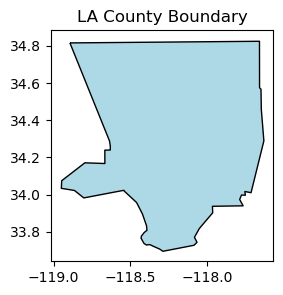

                                            geometry
0  POLYGON ((-118.89723 34.81891, -118.63948 34.2...


In [13]:
la_county_filepath='/home1/kojoseph/anthropogenic-heat-la-20230205/data/boundaries/la_county_bound_simplified_3.geojson'
la_county_gdf = gpd.read_file(la_county_filepath)

# Plot
fig, ax = plt.subplots(figsize=(3, 3))
la_county_gdf.plot(ax=ax, color='lightblue', edgecolor='black')
ax.set_title("LA County Boundary")
plt.show()

print(la_county_gdf)

In [14]:
print(ds_nonan.crs)
print(la_county_gdf.crs)

EPSG:32611
epsg:4326


LA County AHF

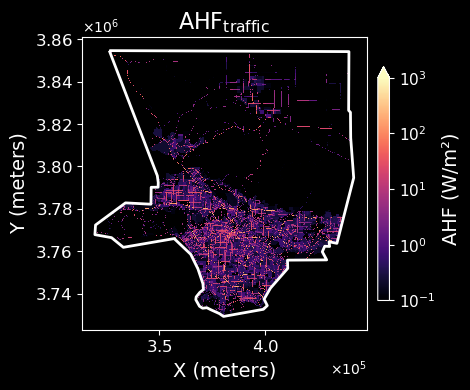

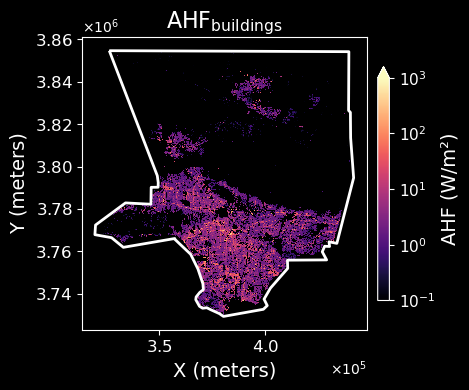

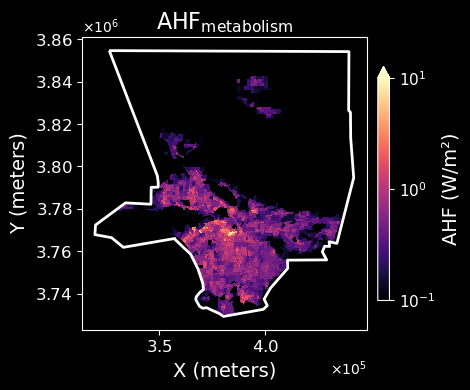

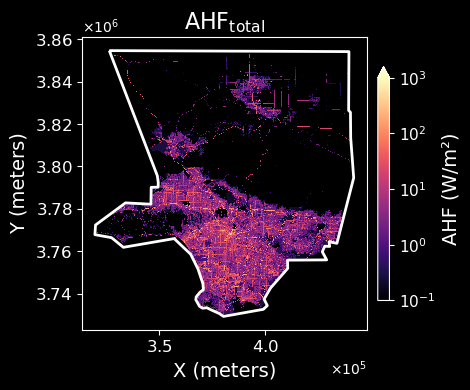

In [106]:
# Separate figures (one file/figure per variable)
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import ScalarFormatter

out_dir = os.path.join(plot_dir, 'ahf_maps')
os.makedirs(out_dir, exist_ok=True)

variables = ["ahf_t", "ahf_b", "ahf_m", "ahf_tot"]
cmaps = ["magma"]*4
vmax_values = [1000, 1000, 10, 1000]
vmin = 0.1
titles = [r"AHF$_{\mathrm{traffic}}$", r"AHF$_{\mathrm{buildings}}$",
          r"AHF$_{\mathrm{metabolism}}$", r"AHF$_{\mathrm{total}}$"]

title_fs = 16
label_fs = 14
tick_fs = 12
cb_label_fs = 14

for i, var in enumerate(variables):
    fig, ax = plt.subplots(figsize=(6, 4))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')

    im = ds_nonan[var].plot.imshow(
        x='x', y='y',
        cmap=cmaps[i],
        norm=LogNorm(vmin=vmin, vmax=vmax_values[i]),
        interpolation='none',
        ax=ax,
        add_colorbar=False
    )

    # white county outline
    la_county_gdf_utm.boundary.plot(ax=ax, color='white', linewidth=2)

    ax.set_aspect('equal')
    ax.set_title(titles[i], fontsize=title_fs, color='white')
    ax.set_xlabel("X (meters)", fontsize=label_fs, color='white')
    ax.set_ylabel("Y (meters)", fontsize=label_fs, color='white')

    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.tick_params(labelsize=tick_fs, colors='white')
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_color('white')
    for spine in ax.spines.values():
        spine.set_color('white')

    cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.02, extend='max')
    cbar.set_label("AHF (W/m²)", fontsize=cb_label_fs, color='white')
    cbar.ax.tick_params(labelsize=tick_fs-1, colors='white')
    for lbl in cbar.ax.get_yticklabels():
        lbl.set_color('white')
    try:
        cbar.outline.set_edgecolor('white')
    except Exception:
        pass

    fig.tight_layout()
    savepath = os.path.join(out_dir, f"ahf_{var}.png")
    fig.savefig(savepath, dpi=300, facecolor='black', bbox_inches='tight')
    plt.show()
    plt.close(fig)

Zoomed-in figures

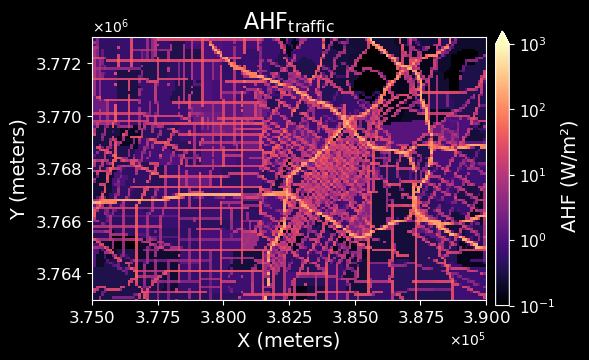

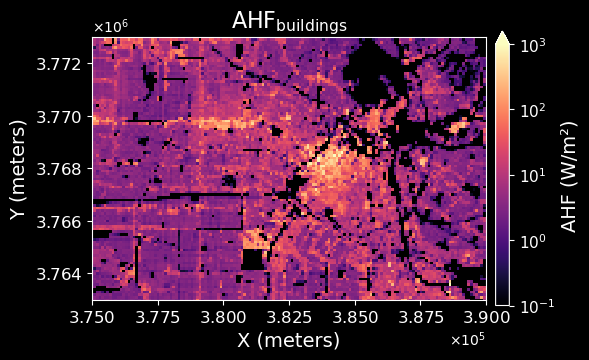

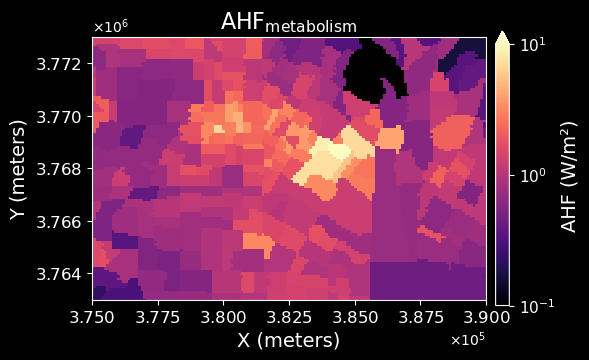

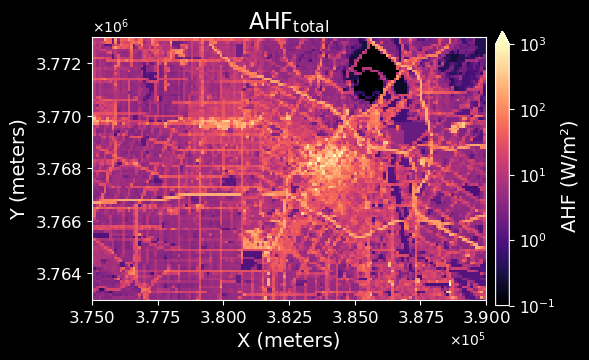

In [107]:
# zoomed separate figures (one file/figure per variable)
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import ScalarFormatter

# Define zoomed-in limits (in meters)
xlim_zoom = (3.75e5, 3.9e5)
ylim_zoom = (3.763e6, 3.773e6)

variables = ["ahf_t", "ahf_b", "ahf_m", "ahf_tot"]
cmaps = ["magma"]*4
vmax_values = [1000, 1000, 10, 1000]
vmin = 0.1
titles = [r"AHF$_{\mathrm{traffic}}$", r"AHF$_{\mathrm{buildings}}$",
          r"AHF$_{\mathrm{metabolism}}$", r"AHF$_{\mathrm{total}}$"]

title_fs = 16
label_fs = 14
tick_fs = 12
cb_label_fs = 14

out_dir = os.path.join(plot_dir, 'ahf_maps_zoomed')
os.makedirs(out_dir, exist_ok=True)

for i, var in enumerate(variables):
    fig, ax = plt.subplots(figsize=(6, 4))
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')

    im = ds_nonan[var].plot.imshow(
        x='x', y='y',
        cmap=cmaps[i],
        norm=LogNorm(vmin=vmin, vmax=vmax_values[i]),
        interpolation='none',
        ax=ax,
        add_colorbar=False
    )

    # white county outline
    la_county_gdf_utm.boundary.plot(ax=ax, color='white', linewidth=2)

    # apply zoomed extent (x/y in meters)
    ax.set_xlim(xlim_zoom)
    ax.set_ylim(ylim_zoom)

    ax.set_aspect('equal')
    ax.set_title(titles[i], fontsize=title_fs, color='white')
    ax.set_xlabel("X (meters)", fontsize=label_fs, color='white')
    ax.set_ylabel("Y (meters)", fontsize=label_fs, color='white')

    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.tick_params(labelsize=tick_fs, colors='white')
    for lbl in ax.get_xticklabels() + ax.get_yticklabels():
        lbl.set_color('white')
    for spine in ax.spines.values():
        spine.set_color('white')

    cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.02, extend='max')
    cbar.set_label("AHF (W/m²)", fontsize=cb_label_fs, color='white')
    cbar.ax.tick_params(labelsize=tick_fs-1, colors='white')
    for lbl in cbar.ax.get_yticklabels():
        lbl.set_color('white')
    try:
        cbar.outline.set_edgecolor('white')
    except Exception:
        pass

    fig.tight_layout()
    savepath = os.path.join(out_dir, f"ahf_zoomed_{var}.png")
    fig.savefig(savepath, dpi=300, facecolor='black', bbox_inches='tight')
    plt.show()
    plt.close(fig)

# Default-Control

In [95]:
# import deltas data
deltas = {}
data_dir = '/home1/kojoseph/ah-la-paper/data/deltas-urban-wrf'
nc_files = glob.glob(f"{data_dir}/*.nc")
for f in nc_files:
    filename = os.path.basename(f)
    delta_id = filename.split('.')[0]
    ds = xr.open_dataset(f)
    deltas[delta_id] = ds

In [98]:
out_dir = os.path.join(plot_dir, 'default-ah-air-temp-results')
os.makedirs(out_dir, exist_ok=True)

## T2

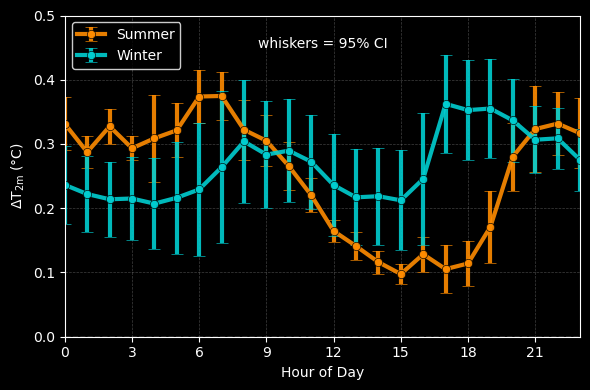

Summer: Max mean at hour 7 with value 0.375
Summer: Min mean at hour 15 with value 0.098
Winter: Max mean at hour 17 with value 0.362
Winter: Min mean at hour 4 with value 0.207


In [99]:
# Diurnal plot for delta(T2) with black background
v = 'T2'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_default'
control = 'ah_off'
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour']==0])
    err_diurnal = 1.96*(std_diurnal/(n_sample)**(1/2))
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal

# initiate plot (black background)
fig, ax = plt.subplots(figsize=(6,4))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

hrs = range(24)
# horizontal zero line
ax.axhline(y=0, color='white', linestyle='--', linewidth=1, alpha=0.6)

# summer
ax.errorbar(
    hrs,
    mean_dict[8].values,
    yerr=[mean_dict[8].values - ci_lower[8].values, ci_upper[8].values - mean_dict[8].values],
    fmt='o-', color=orange, label='Summer', linewidth=3, alpha=0.9, capsize=4, capthick=2,
    markeredgecolor='black', markeredgewidth=0.5
)
# winter
ax.errorbar(
    hrs,
    mean_dict[12].values,
    yerr=[mean_dict[12].values - ci_lower[12].values, ci_upper[12].values - mean_dict[12].values],
    fmt='o-', color=cyan, label='Winter', linewidth=3, alpha=0.9, capsize=4, capthick=2,
    markeredgecolor='black', markeredgewidth=0.5
)

# styling for dark background
ax.xaxis.set_ticks(np.arange(0,24,3))
ax.grid(linewidth=0.5, alpha=0.25, linestyle='--', color='white')
ax.set_xlabel('Hour of Day', color='white')
ax.set_ylabel(del_ta_label, color='white')
ax.set_xlim(0, 23)
ax.set_ylim(0, 0.5)

# ticks, spines, legend, annotation in white
ax.tick_params(labelcolor='white', colors='white')
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_color('white')
for spine in ax.spines.values():
    spine.set_color('white')

leg = ax.legend(frameon=True)
leg.get_frame().set_facecolor('black')
leg.get_frame().set_edgecolor('white')
for text in leg.get_texts():
    text.set_color('white')

ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction',
            fontsize=10, ha='center', color='white')

plt.tight_layout()
# save plot with black background
save_filename = 'diurnal-lineplot-t2-default.png'
save_filepath = os.path.join(out_dir, save_filename)
plt.savefig(save_filepath, dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight')
plt.show()
plt.close(fig)

# Print the max value and time of max value
# For summer (month 8)
max_idx_summer = np.argmax(mean_dict[8].values)
max_hour_summer = mean_dict[8]['hour'].values[max_idx_summer]
max_val_summer = mean_dict[8].values[max_idx_summer]
min_idx_summer = np.argmin(mean_dict[8].values)
min_hour_summer = mean_dict[8]['hour'].values[min_idx_summer]
min_val_summer = mean_dict[8].values[min_idx_summer]
print(f"Summer: Max mean at hour {max_hour_summer} with value {max_val_summer:.3f}")
print(f"Summer: Min mean at hour {min_hour_summer} with value {min_val_summer:.3f}")

# For winter (month 12)
max_idx_winter = np.argmax(mean_dict[12].values)
max_hour_winter = mean_dict[12]['hour'].values[max_idx_winter]
max_val_winter = mean_dict[12].values[max_idx_winter]
min_idx_winter = np.argmin(mean_dict[12].values)
min_hour_winter = mean_dict[12]['hour'].values[min_idx_winter]
min_val_winter = mean_dict[12].values[min_idx_winter]
print(f"Winter: Max mean at hour {max_hour_winter} with value {max_val_winter:.3f}")
print(f"Winter: Min mean at hour {min_hour_winter} with value {min_val_winter:.3f}")

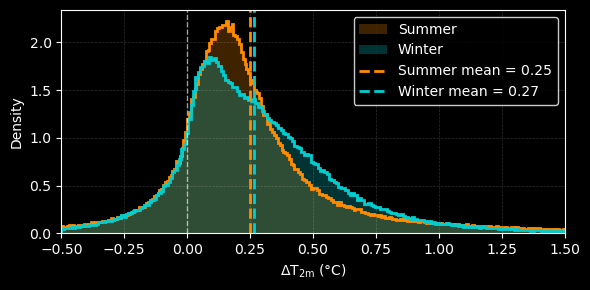

In [100]:
import matplotlib.colors as mcolors
# Distribution of deltas (black background)
fig, ax = plt.subplots(figsize=(6,3))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

xlim = (-0.5, 1.5)

# get data
delta_dict = {}
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta_dict[m] = deltas[delta_id][v]
delta_summer = delta_dict[8].values.flatten()
delta_summer = delta_summer[~np.isnan(delta_summer)]
delta_winter = delta_dict[12].values.flatten()
delta_winter = delta_winter[~np.isnan(delta_winter)]

# RGBA fills for dark background
fc_s = mcolors.to_rgba(orange, 0.25)
fc_w = mcolors.to_rgba(cyan, 0.25)

# Summer: filled histogram + edge
n_s, bins_s, _ = ax.hist(
    delta_summer, bins='auto', range=xlim, label='Summer',
    histtype='stepfilled', density=True,
    facecolor=fc_s, edgecolor='none'
)
ax.hist(
    delta_summer, bins=bins_s, range=xlim,
    histtype='step', density=True,
    color=orange, linewidth=2, alpha=1
)

# Winter: filled histogram + edge
n_w, bins_w, _ = ax.hist(
    delta_winter, bins='auto', range=xlim, label='Winter',
    histtype='stepfilled', density=True,
    facecolor=fc_w, edgecolor='none'
)
ax.hist(
    delta_winter, bins=bins_w, range=xlim,
    histtype='step', density=True,
    color=cyan, linewidth=2, alpha=1
)

# Plot means
mean_val_s = np.mean(delta_summer)
mean_val_w = np.mean(delta_winter)
ax.axvline(mean_val_s, color=orange, linestyle='--', linewidth=2, label=f'Summer mean = {mean_val_s:.2f}')
ax.axvline(mean_val_w, color=cyan, linestyle='--', linewidth=2, label=f'Winter mean = {mean_val_w:.2f}')

# zero line (white)
ax.axvline(x=0, color='white', linestyle='--', linewidth=1, alpha=0.6)

# styling for dark background
ax.set_xlabel(del_ta_label, color='white')
ax.set_ylabel('Density', color='white')
ax.set_xlim(xlim)
ax.grid(linewidth=0.5, alpha=0.18, linestyle='--', color='white')

# ticks, spines, legend in white
ax.tick_params(labelcolor='white', colors='white')
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_color('white')
for spine in ax.spines.values():
    spine.set_color('white')

leg = ax.legend(frameon=True)
leg.get_frame().set_facecolor('black')
leg.get_frame().set_edgecolor('white')
for text in leg.get_texts():
    text.set_color('white')

plt.tight_layout()
save_filename = 'hist-t2-default.png'
save_filepath = os.path.join(out_dir, save_filename)
plt.savefig(save_filepath, dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight')
plt.show()
plt.close(fig)

Heatmap frames

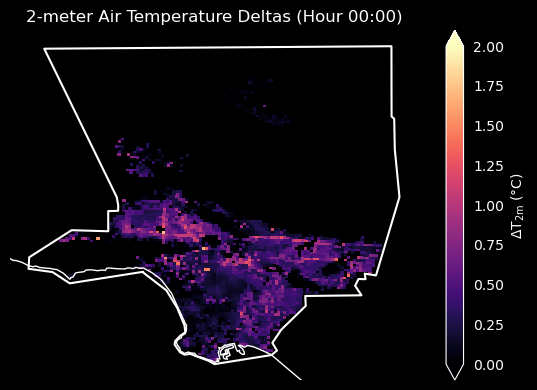

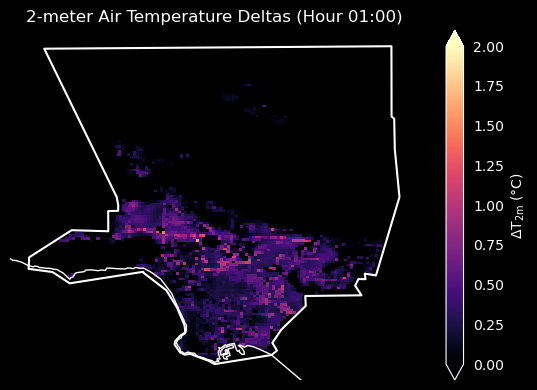

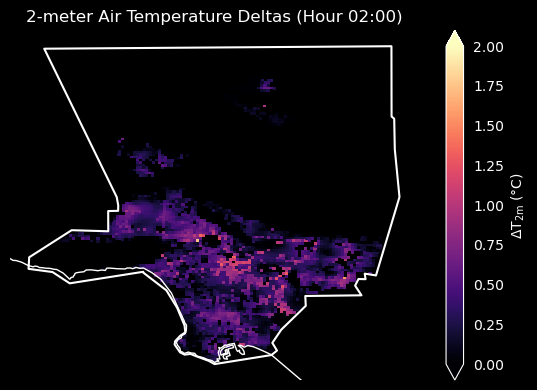

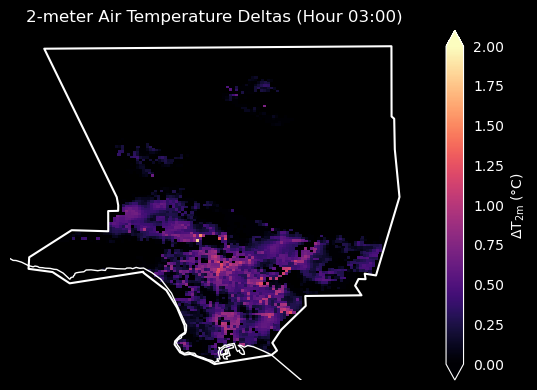

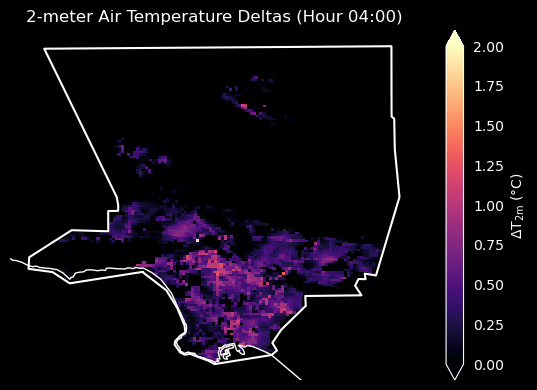

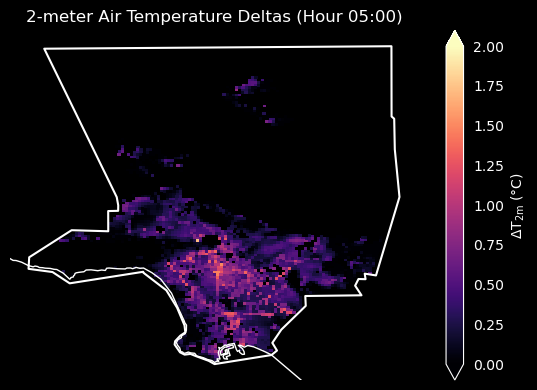

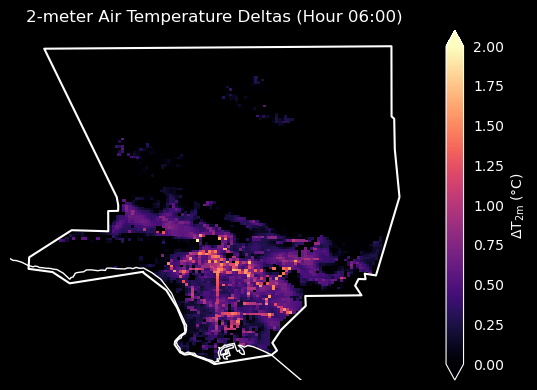

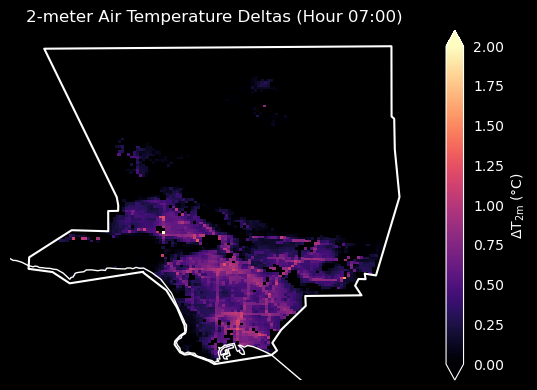

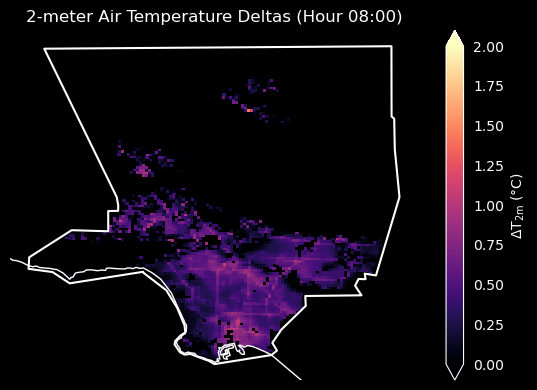

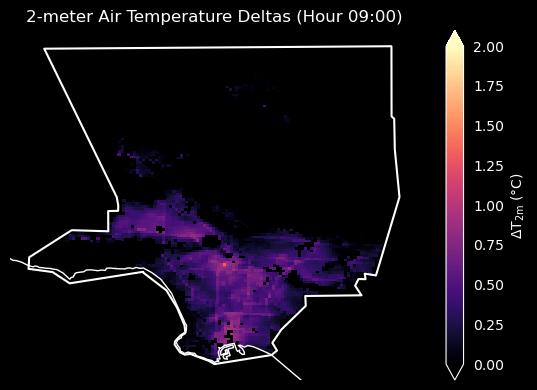

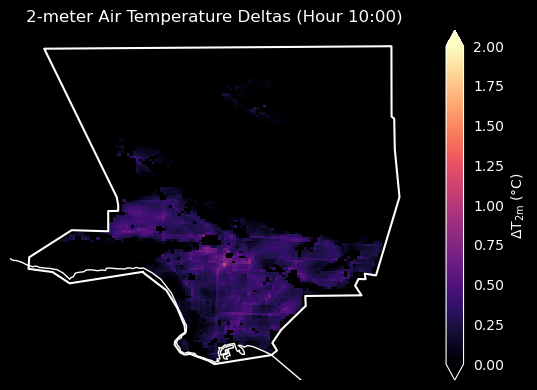

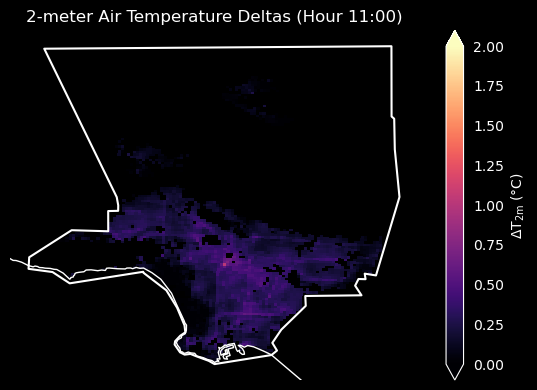

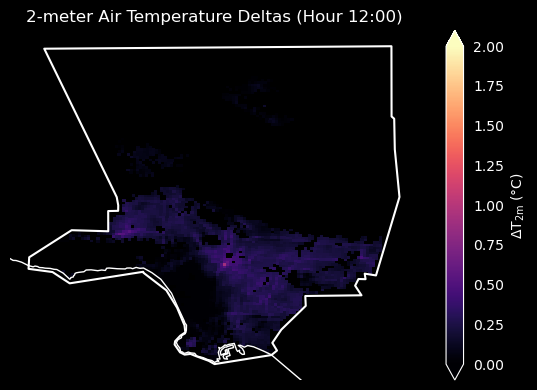

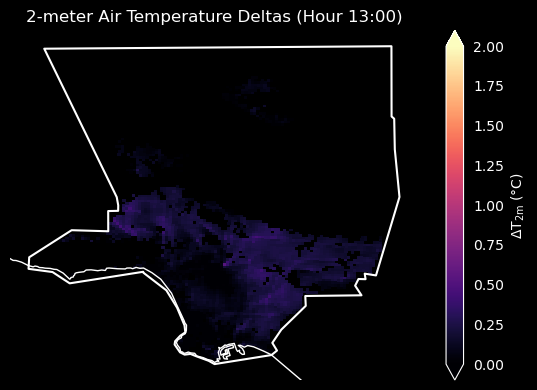

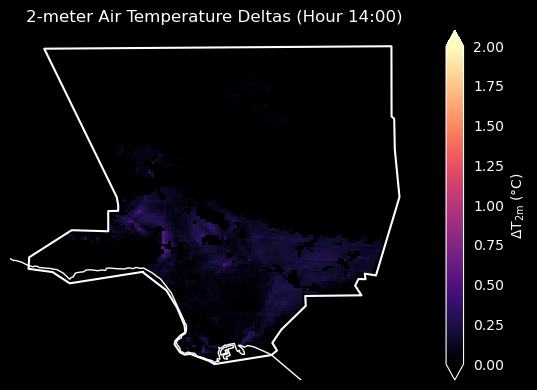

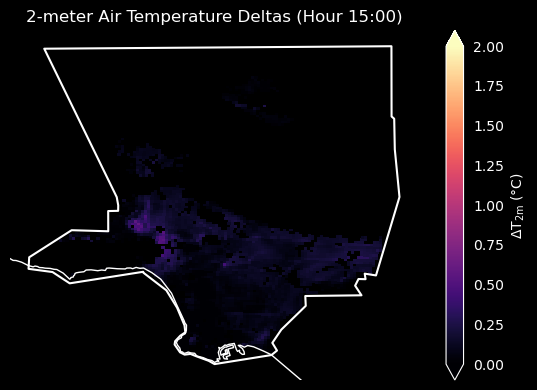

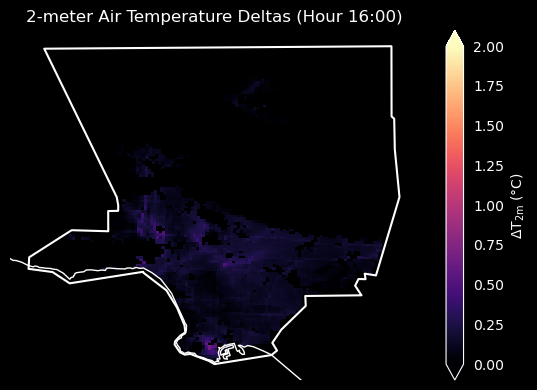

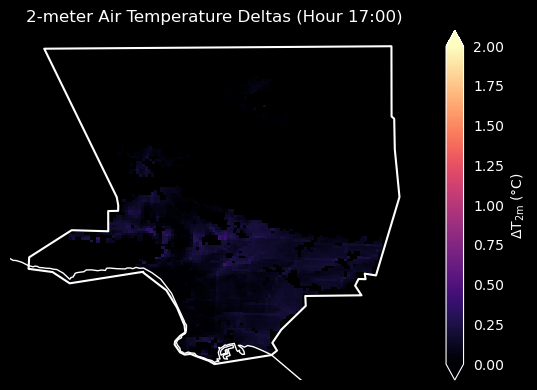

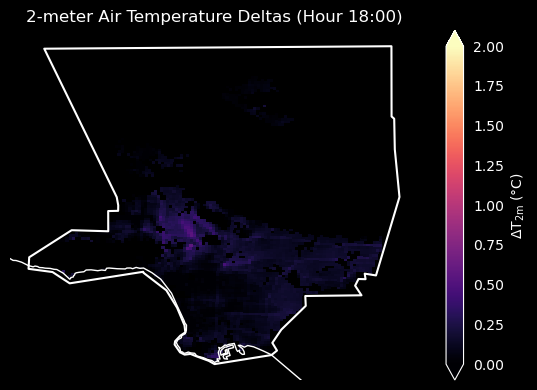

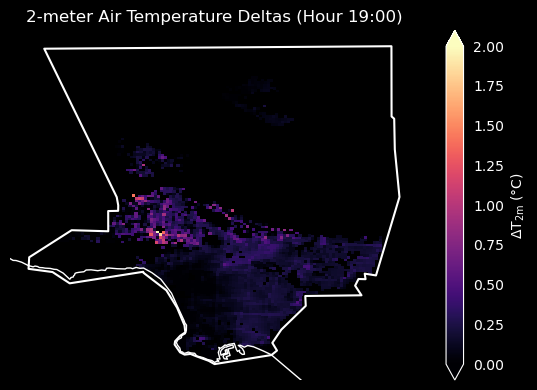

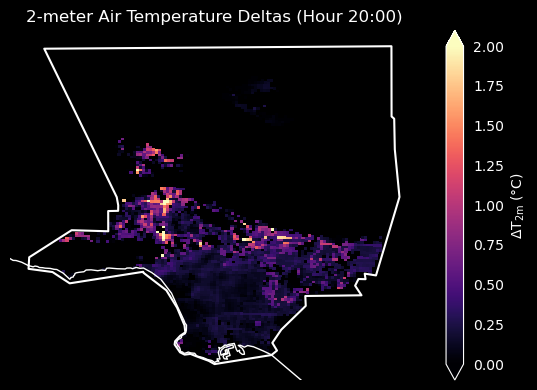

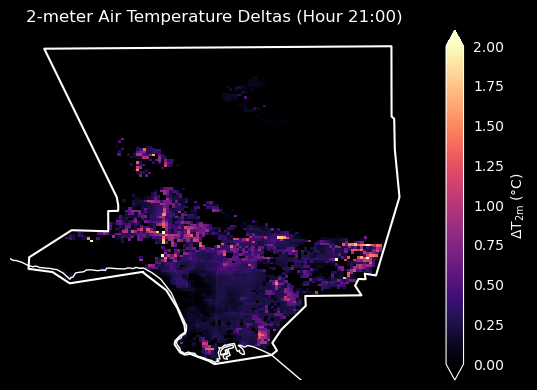

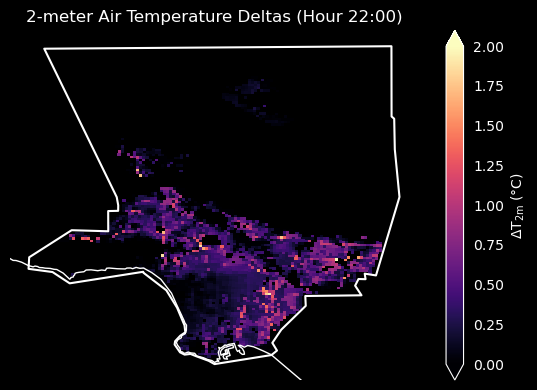

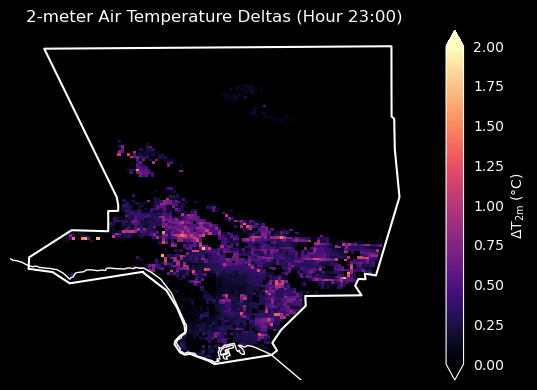

In [101]:
delta_id = f'{control}-{target}-08'
delta_clipped = deltas[delta_id][v]
delta_clipped = delta_clipped.groupby('hour').mean('Time')
lat = delta_clipped['XLAT'][:]
lon = delta_clipped['XLONG'][:]

# ensure LA county geometry is in lon/lat (WGS84) for PlateCarree
la_county_wgs = la_county_gdf.to_crs(epsg=4326)

ani_dir = os.path.join(out_dir, f'{v}_map_frames')
os.makedirs(ani_dir, exist_ok=True)

vmin, vmax = 0, 2
# compute extent from LA county bounds with a 5% padding
minx, miny, maxx, maxy = la_county_wgs.total_bounds
pad_frac = 0.05
dx = maxx - minx
dy = maxy - miny
extent = [minx - dx * pad_frac, maxx + dx * pad_frac, miny - dy * pad_frac, maxy + dy * pad_frac]

for i in range(len(delta_clipped['hour'])):
    z = delta_clipped.isel(hour=i)

    fig = plt.figure(figsize=(6, 4))
    fig.patch.set_facecolor('black')
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
    ax.set_facecolor('black')
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    pcm = ax.pcolormesh(lon, lat, z, cmap='magma', shading='auto', vmin=vmin, vmax=vmax, zorder=1)

    # LA county boundary (draw on top)
    for geom in la_county_wgs.geometry:
        ax.add_geometries([geom], crs=ccrs.PlateCarree(),
                          facecolor='none', edgecolor='white', linewidth=1.5, zorder=5)

    ax.coastlines(color='white', zorder=4)
    # ax.gridlines(draw_labels=['left', 'bottom'],
    #              linewidth=1, alpha=0.3, color='white')

    cbar = fig.colorbar(pcm, ax=ax, extend='both')
    cbar.set_label(del_ta_label, color='white')
    for label in cbar.ax.get_yticklabels():
        label.set_color('white')
    cbar.outline.set_edgecolor('white')

    hour_val = int(delta_clipped['hour'].isel(hour=i).item())
    ax.set_title(f"2-meter Air Temperature Deltas (Hour {hour_val:02d}:00)", color='white')

    plt.tight_layout()
    fname = os.path.join(ani_dir, f"delta-t2-frame-{i:03d}.png")
    fig.savefig(fname, dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight')
    plt.show()
    plt.close(fig)

## TC

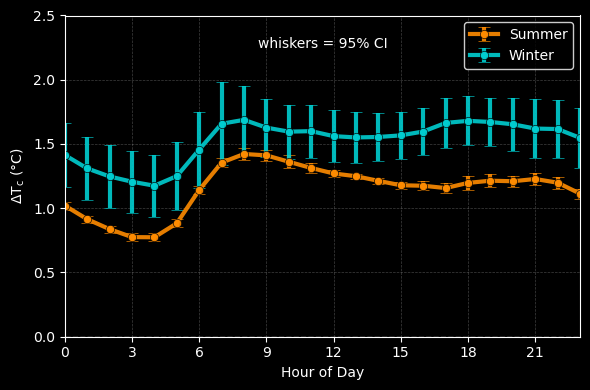

Summer: Max mean at hour 8 with value 1.422
Summer: Min mean at hour 4 with value 0.774
Winter: Max mean at hour 8 with value 1.688
Winter: Min mean at hour 4 with value 1.175


In [102]:
v = 'TC_URB'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_default'
control = 'ah_off'
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour']==0])
    err_diurnal = 1.96*(std_diurnal/(n_sample)**(1/2))
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal

# colors for dark background
orange = "#FF8C00"
cyan = "#00CED1"

# initiate plot (black background)
fig, ax = plt.subplots(figsize=(6,4))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

hrs = range(24)
# horizontal zero line
ax.axhline(y=0, color='white', linestyle='--', linewidth=1, alpha=0.6)

# summer
ax.errorbar(
    hrs,
    mean_dict[8].values,
    yerr=[mean_dict[8].values - ci_lower[8].values, ci_upper[8].values - mean_dict[8].values],
    fmt='o-', color=orange, label='Summer', linewidth=3, alpha=0.9, capsize=4, capthick=2,
    markeredgecolor='black', markeredgewidth=0.5
)
# winter
ax.errorbar(
    hrs,
    mean_dict[12].values,
    yerr=[mean_dict[12].values - ci_lower[12].values, ci_upper[12].values - mean_dict[12].values],
    fmt='o-', color=cyan, label='Winter', linewidth=3, alpha=0.9, capsize=4, capthick=2,
    markeredgecolor='black', markeredgewidth=0.5
)

# styling for dark background
ax.xaxis.set_ticks(np.arange(0,24,3))
ax.grid(linewidth=0.5, alpha=0.25, linestyle='--', color='white')
ax.set_xlabel('Hour of Day', color='white')
ax.set_ylabel(del_tc_label, color='white')
ax.set_xlim(0, 23)
ax.set_ylim(0, 2.5)

# ticks, spines, legend, annotation in white
ax.tick_params(labelcolor='white', colors='white')
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_color('white')
for spine in ax.spines.values():
    spine.set_color('white')

leg = ax.legend(frameon=True)
leg.get_frame().set_facecolor('black')
leg.get_frame().set_edgecolor('white')
for text in leg.get_texts():
    text.set_color('white')

ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction',
            fontsize=10, ha='center', color='white')

plt.tight_layout()
save_filename = 'diurnal-lineplot-tc-default.png'
save_filepath = os.path.join(out_dir, save_filename)
plt.savefig(save_filepath, dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight')
plt.show()
plt.close(fig)

# Print the max/min values and times
max_idx_summer = np.argmax(mean_dict[8].values)
max_hour_summer = mean_dict[8]['hour'].values[max_idx_summer]
max_val_summer = mean_dict[8].values[max_idx_summer]
min_idx_summer = np.argmin(mean_dict[8].values)
min_hour_summer = mean_dict[8]['hour'].values[min_idx_summer]
min_val_summer = mean_dict[8].values[min_idx_summer]
print(f"Summer: Max mean at hour {max_hour_summer} with value {max_val_summer:.3f}")
print(f"Summer: Min mean at hour {min_hour_summer} with value {min_val_summer:.3f}")

max_idx_winter = np.argmax(mean_dict[12].values)
max_hour_winter = mean_dict[12]['hour'].values[max_idx_winter]
max_val_winter = mean_dict[12].values[max_idx_winter]
min_idx_winter = np.argmin(mean_dict[12].values)
min_hour_winter = mean_dict[12]['hour'].values[min_idx_winter]
min_val_winter = mean_dict[12].values[min_idx_winter]
print(f"Winter: Max mean at hour {max_hour_winter} with value {max_val_winter:.3f}")
print(f"Winter: Min mean at hour {min_hour_winter} with value {min_val_winter:.3f}")

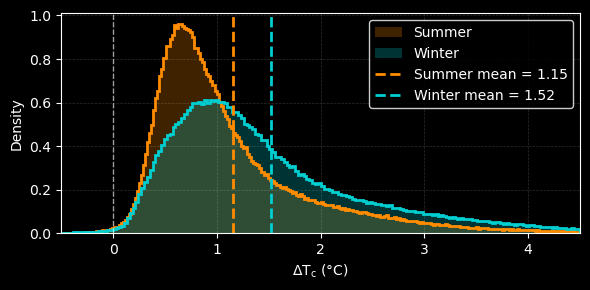

In [103]:
import matplotlib.colors as mcolors
# Distribution of deltas (black background)
fig, ax = plt.subplots(figsize=(6,3))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

xlim = (-0.5, 4.50)

# get data
delta_dict = {}
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta_dict[m] = deltas[delta_id][v]
delta_summer = delta_dict[8].values.flatten()
delta_summer = delta_summer[~np.isnan(delta_summer)]
delta_winter = delta_dict[12].values.flatten()
delta_winter = delta_winter[~np.isnan(delta_winter)]

# RGBA fills for dark background using existing color vars
fc_s = mcolors.to_rgba(orange, 0.25)
fc_w = mcolors.to_rgba(cyan, 0.25)

# Summer: filled histogram + edge
n_s, bins_s, _ = ax.hist(
    delta_summer, bins='auto', range=xlim, label='Summer',
    histtype='stepfilled', density=True,
    facecolor=fc_s, edgecolor='none'
)
ax.hist(
    delta_summer, bins=bins_s, range=xlim,
    histtype='step', density=True,
    color=orange, linewidth=2, alpha=1
)

# Winter: filled histogram + edge
n_w, bins_w, _ = ax.hist(
    delta_winter, bins='auto', range=xlim, label='Winter',
    histtype='stepfilled', density=True,
    facecolor=fc_w, edgecolor='none'
)
ax.hist(
    delta_winter, bins=bins_w, range=xlim,
    histtype='step', density=True,
    color=cyan, linewidth=2, alpha=1
)

# Plot means
mean_val_s = np.mean(delta_summer)
mean_val_w = np.mean(delta_winter)
ax.axvline(mean_val_s, color=orange, linestyle='--', linewidth=2, label=f'Summer mean = {mean_val_s:.2f}')
ax.axvline(mean_val_w, color=cyan, linestyle='--', linewidth=2, label=f'Winter mean = {mean_val_w:.2f}')

# zero line (white)
ax.axvline(x=0, color='white', linestyle='--', linewidth=1, alpha=0.6)

# styling for dark background
ax.set_xlabel(del_tc_label, color='white')
ax.set_ylabel('Density', color='white')
ax.set_xlim(xlim)
ax.grid(linewidth=0.5, alpha=0.18, linestyle='--', color='white')

# ticks, spines, legend in white
ax.tick_params(labelcolor='white', colors='white')
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_color('white')
for spine in ax.spines.values():
    spine.set_color('white')

leg = ax.legend(frameon=True)
leg.get_frame().set_facecolor('black')
leg.get_frame().set_edgecolor('white')
for text in leg.get_texts():
    text.set_color('white')

plt.tight_layout()
save_filename = 'hist-tc-default-dark.png'
save_filepath = os.path.join(out_dir, save_filename)
plt.savefig(save_filepath, dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight')
plt.show()
plt.close(fig)

Heatmap frames

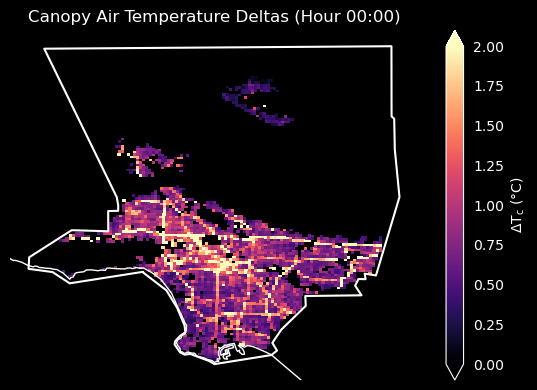

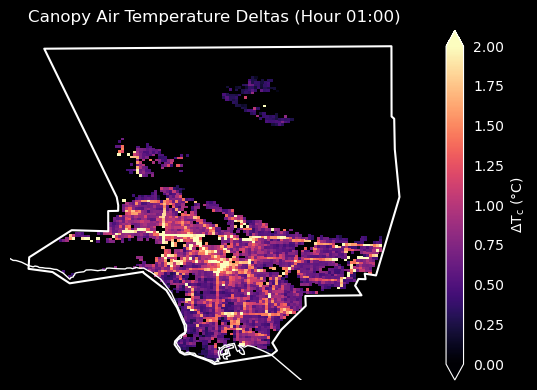

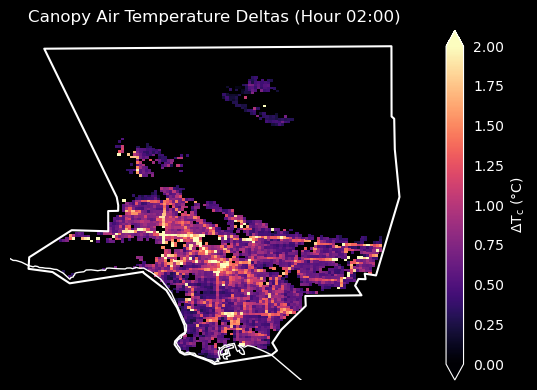

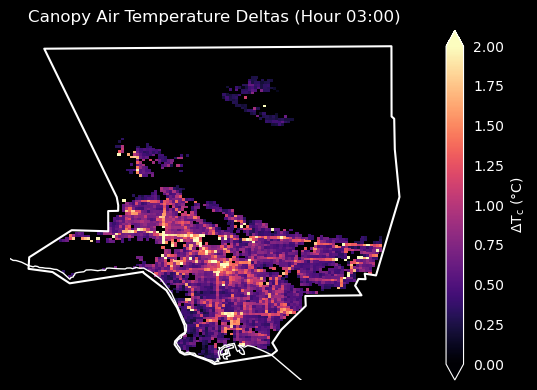

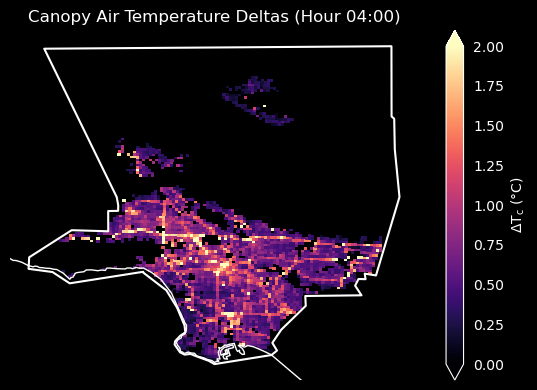

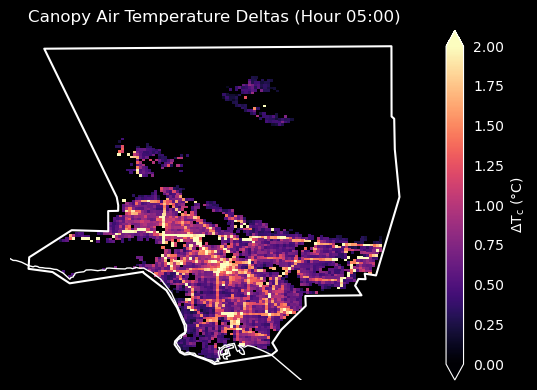

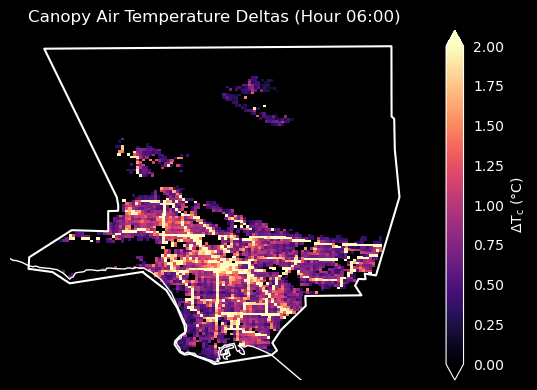

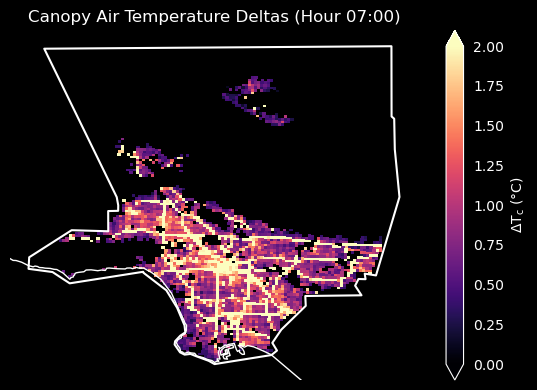

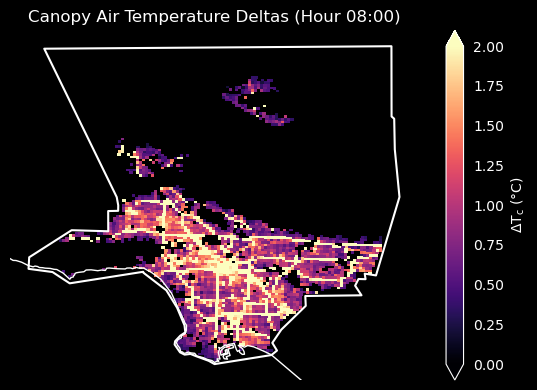

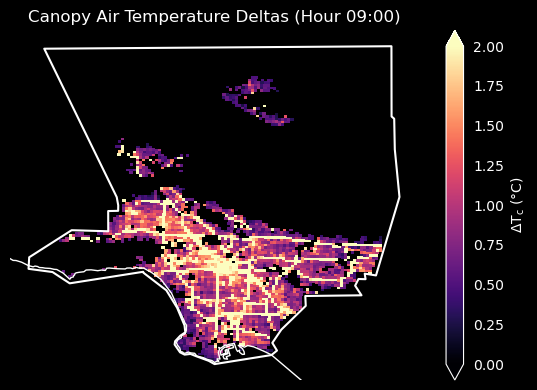

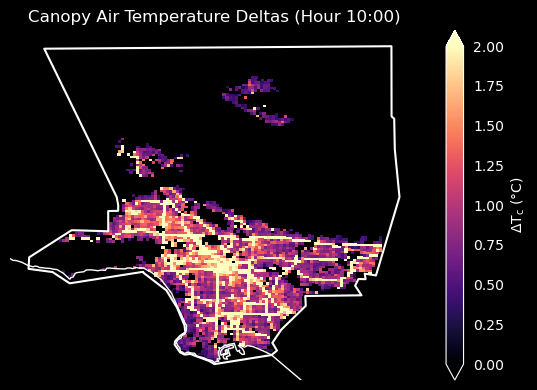

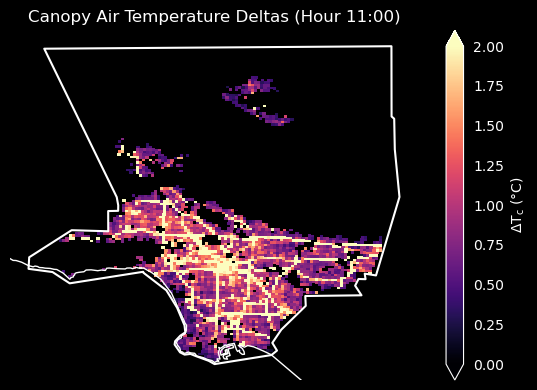

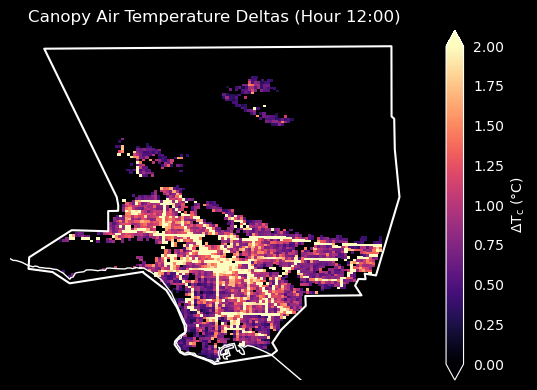

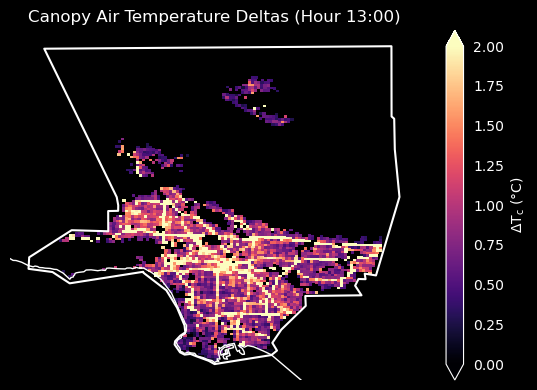

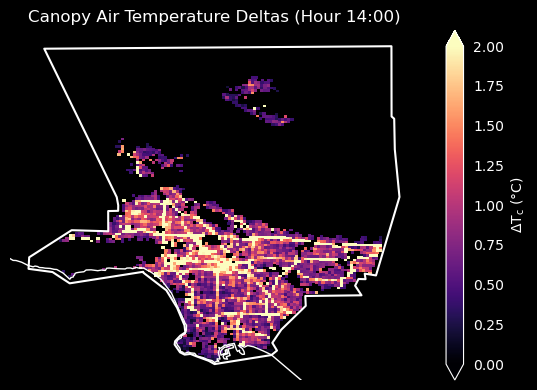

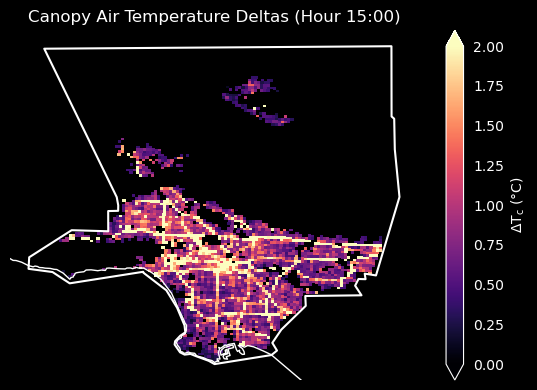

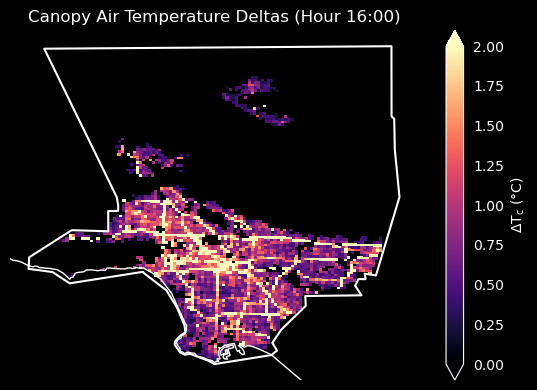

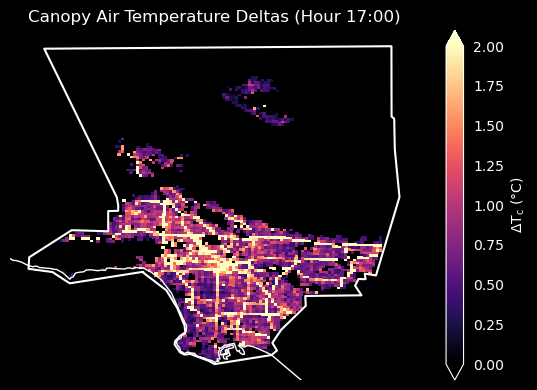

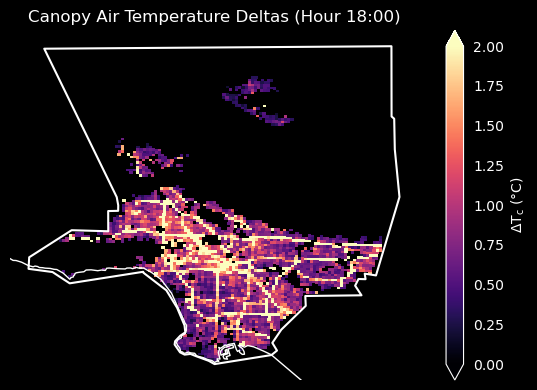

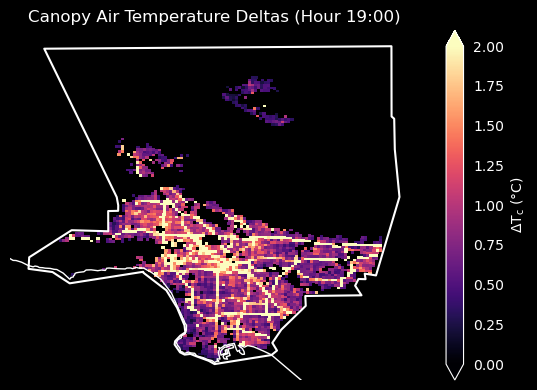

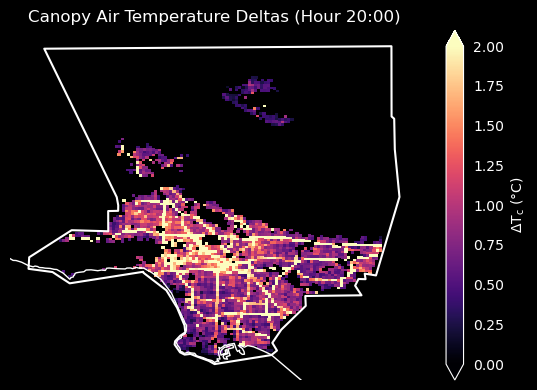

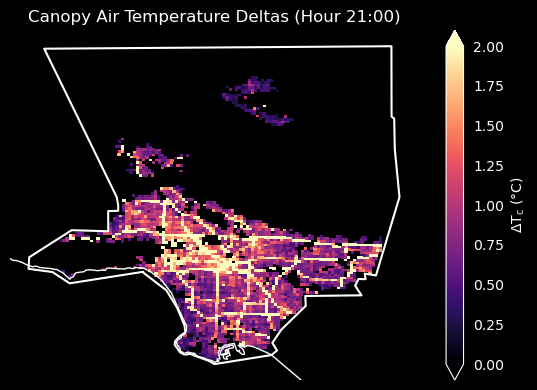

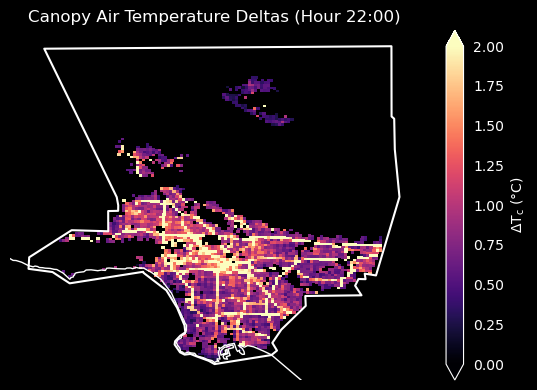

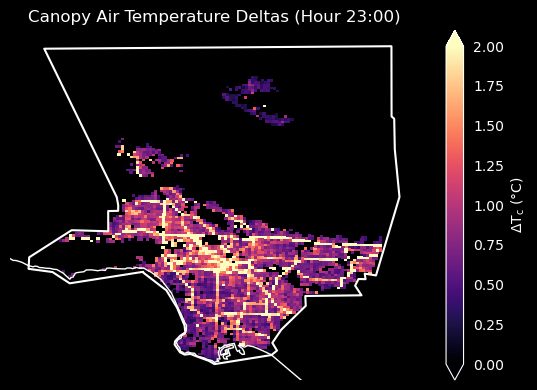

In [105]:
delta_id = f'{control}-{target}-08'
delta_clipped = deltas[delta_id][v]
delta_clipped = delta_clipped.groupby('hour').mean('Time')
lat = delta_clipped['XLAT'][:]
lon = delta_clipped['XLONG'][:]
# ensure LA county geometry is in lon/lat (WGS84) for PlateCarree
la_county_wgs = la_county_gdf.to_crs(epsg=4326)

ani_dir = os.path.join(out_dir, f'{v}_map_frames')
os.makedirs(ani_dir, exist_ok=True)

vmin, vmax = 0, 2
# extent = [-119, -117.5, 33.3, 34.8]
# compute extent from LA county bounds with a 5% padding
minx, miny, maxx, maxy = la_county_wgs.total_bounds
pad_frac = 0.05
dx = maxx - minx
dy = maxy - miny
extent = [minx - dx * pad_frac, maxx + dx * pad_frac, miny - dy * pad_frac, maxy + dy * pad_frac]

for i in range(len(delta_clipped['hour'])):
    z = delta_clipped.isel(hour=i)

    fig = plt.figure(figsize=(6, 4))
    fig.patch.set_facecolor('black')
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
    ax.set_facecolor('black')
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    pcm = ax.pcolormesh(lon, lat, z, cmap='magma', shading='auto', vmin=vmin, vmax=vmax, zorder=1)

    # LA county boundary (draw on top)
    for geom in la_county_wgs.geometry:
        ax.add_geometries([geom], crs=ccrs.PlateCarree(),
                          facecolor='none', edgecolor='white', linewidth=1.5, zorder=5)

    ax.coastlines(color='white', zorder=4)
    # ax.gridlines(draw_labels=['left', 'bottom'],
    #              linewidth=1, alpha=0.3, color='white')

    cbar = fig.colorbar(pcm, ax=ax, extend='both')
    cbar.set_label(del_tc_label, color='white')
    for label in cbar.ax.get_yticklabels():
        label.set_color('white')
    cbar.outline.set_edgecolor('white')

    ax.set_title(f"Canopy Air Temperature Deltas (Hour {i:02d}:00)", color='white')
    plt.tight_layout()
    fname = os.path.join(ani_dir, f"delta-tc-frame-{i:03d}.png")
    fig.savefig(fname, dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight')
    plt.show()
    plt.close(fig)

# EE Mitigation Potential

In [79]:
print(list(deltas.keys()))

['ah_default-ah_elec_low-08', 'ah_off-ah_default-12', 'ah_default-ah_elec_medium-08', 'ah_default-ah_elec_high-12', 'ah_default-ah_elec_low-12', 'ah_default-ah_elec_medium-12', 'ah_default-ah_elec_high-08', 'ah_off-ah_default-08']


/home1/kojoseph/ah-la-paper/figs/figs-for-kelly/ee-lineplots/diurnal-ah_default-ah_elec_low-t2.png


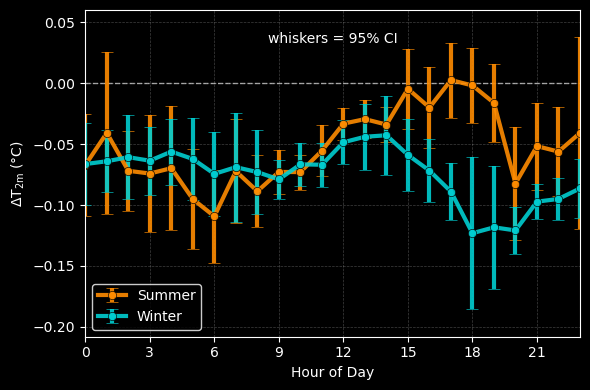

T2 | ah_elec_low / ah_default | Summer: Max at hour 17 = 0.003, Min at hour 6 = -0.109
T2 | ah_elec_low / ah_default | Winter: Max at hour 14 = -0.043, Min at hour 18 = -0.123
/home1/kojoseph/ah-la-paper/figs/figs-for-kelly/ee-lineplots/diurnal-ah_default-ah_elec_low-tc_urb.png


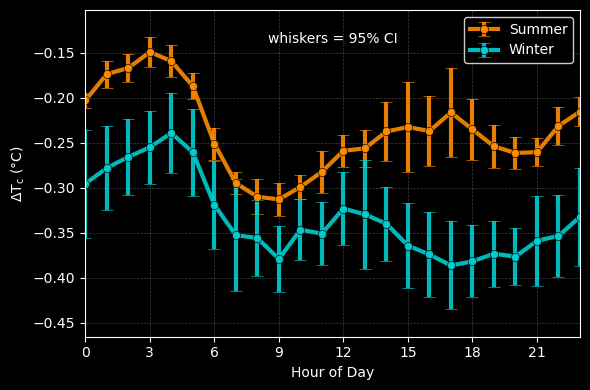

TC_URB | ah_elec_low / ah_default | Summer: Max at hour 3 = -0.149, Min at hour 9 = -0.313
TC_URB | ah_elec_low / ah_default | Winter: Max at hour 4 = -0.239, Min at hour 17 = -0.386
/home1/kojoseph/ah-la-paper/figs/figs-for-kelly/ee-lineplots/diurnal-ah_default-ah_elec_medium-t2.png


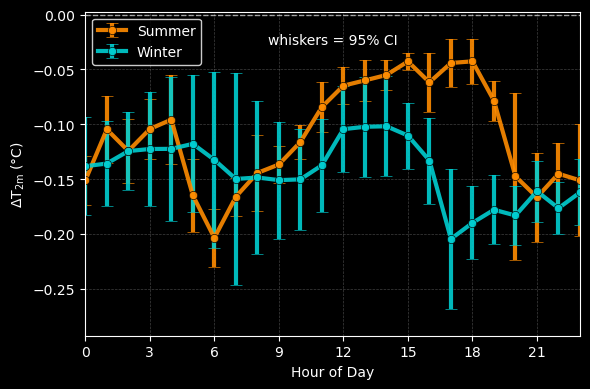

T2 | ah_elec_medium / ah_default | Summer: Max at hour 18 = -0.043, Min at hour 6 = -0.204
T2 | ah_elec_medium / ah_default | Winter: Max at hour 14 = -0.102, Min at hour 17 = -0.205
/home1/kojoseph/ah-la-paper/figs/figs-for-kelly/ee-lineplots/diurnal-ah_default-ah_elec_medium-tc_urb.png


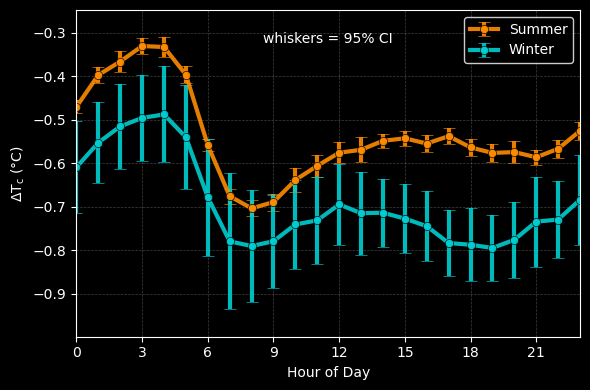

TC_URB | ah_elec_medium / ah_default | Summer: Max at hour 3 = -0.331, Min at hour 8 = -0.704
TC_URB | ah_elec_medium / ah_default | Winter: Max at hour 4 = -0.488, Min at hour 19 = -0.795
/home1/kojoseph/ah-la-paper/figs/figs-for-kelly/ee-lineplots/diurnal-ah_default-ah_elec_high-t2.png


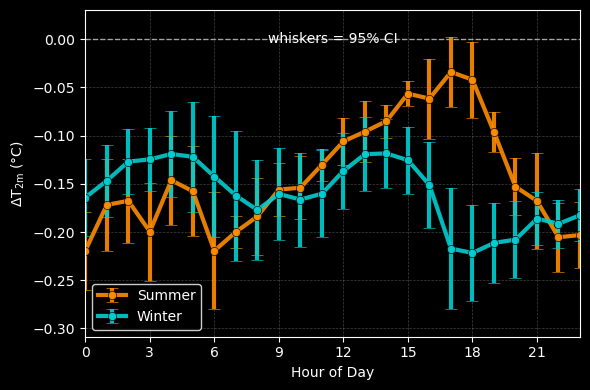

T2 | ah_elec_high / ah_default | Summer: Max at hour 17 = -0.034, Min at hour 6 = -0.219
T2 | ah_elec_high / ah_default | Winter: Max at hour 14 = -0.118, Min at hour 18 = -0.222
/home1/kojoseph/ah-la-paper/figs/figs-for-kelly/ee-lineplots/diurnal-ah_default-ah_elec_high-tc_urb.png


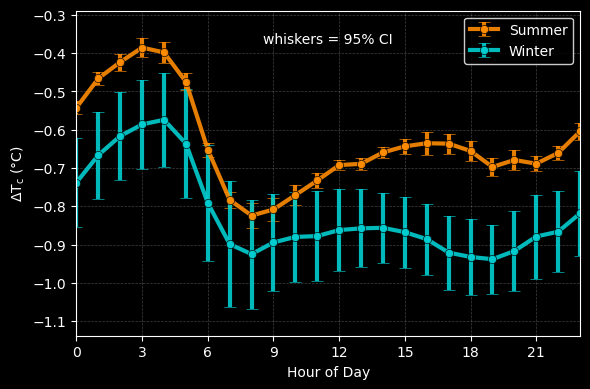

TC_URB | ah_elec_high / ah_default | Summer: Max at hour 3 = -0.386, Min at hour 8 = -0.824
TC_URB | ah_elec_high / ah_default | Winter: Max at hour 4 = -0.574, Min at hour 19 = -0.938


In [91]:
vars_to_plot = ['T2', 'TC_URB']
months = [8, 12]
control = 'ah_default'
targets = ['ah_elec_low', 'ah_elec_medium', 'ah_elec_high']
orange = "#FF8C00"
cyan = "#00CED1"

out_dir = os.path.join(plot_dir, 'ee-lineplots')
os.makedirs(out_dir, exist_ok=True)

for target in targets:
    combo_label = f"{target} / {control}"
    for v in vars_to_plot:
        mean_dict = {}
        ci_lower = {}
        ci_upper = {}

        for m in months:
            delta_id = f'{control}-{target}-{m:02d}'
            base = deltas[delta_id][v].mean(dim=['y','x'], skipna=True)   # mean over space
            # compute diurnal mean, std and per-hour sample counts from 'base'
            mean_diurnal = base.groupby('hour').mean(dim='Time')
            std_diurnal = base.groupby('hour').std(dim='Time')
            counts = base.groupby('hour').count(dim='Time')        # number of Time samples for each hour
            counts = counts.where(counts > 0)                      # avoid divide-by-zero

            err_diurnal = 1.96 * (std_diurnal / np.sqrt(counts))

            mean_dict[m] = mean_diurnal
            ci_lower[m] = mean_diurnal - err_diurnal
            ci_upper[m] = mean_diurnal + err_diurnal

        # plot
        fig, ax = plt.subplots(figsize=(6,4))
        fig.patch.set_facecolor('black')
        ax.set_facecolor('black')

        hrs = mean_dict[8]['hour'].values

        ax.axhline(y=0, color='white', linestyle='--', linewidth=1, alpha=0.6)

        ax.errorbar(
            hrs,
            mean_dict[8].values,
            yerr=[(mean_dict[8].values - ci_lower[8].values), (ci_upper[8].values - mean_dict[8].values)],
            fmt='o-', color=orange, label='Summer', linewidth=3, alpha=0.9, capsize=4, capthick=2,
            markeredgecolor='black', markeredgewidth=0.5
        )
        ax.errorbar(
            hrs,
            mean_dict[12].values,
            yerr=[(mean_dict[12].values - ci_lower[12].values), (ci_upper[12].values - mean_dict[12].values)],
            fmt='o-', color=cyan, label='Winter', linewidth=3, alpha=0.9, capsize=4, capthick=2,
            markeredgecolor='black', markeredgewidth=0.5
        )

        ax.xaxis.set_ticks(np.arange(0,24,3))
        ax.grid(linewidth=0.5, alpha=0.25, linestyle='--', color='white')
        ax.set_xlabel('Hour of Day', color='white')
        ax.set_ylabel(del_tc_label if v == 'TC_URB' else del_ta_label, color='white')
        ax.set_xlim(0, 23)

        # y-limits from combined CI with padding
        all_lows = np.concatenate([ci_lower[8].values, ci_lower[12].values])
        all_highs = np.concatenate([ci_upper[8].values, ci_upper[12].values])
        ymin = np.nanmin(all_lows)
        ymax = np.nanmax(all_highs)
        if np.isfinite(ymin) and np.isfinite(ymax):
            pad = 0.1 * (ymax - ymin) if (ymax - ymin) != 0 else 0.1 * max(abs(ymax), 1)
            ax.set_ylim(ymin - pad, ymax + pad)

        ax.tick_params(labelcolor='white', colors='white')
        for lbl in ax.get_xticklabels() + ax.get_yticklabels():
            lbl.set_color('white')
        for spine in ax.spines.values():
            spine.set_color('white')

        leg = ax.legend(frameon=True)
        leg.get_frame().set_facecolor('black')
        leg.get_frame().set_edgecolor('white')
        for text in leg.get_texts():
            text.set_color('white')

        ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction',
                    fontsize=10, ha='center', color='white')

        plt.tight_layout()
        fname = f"diurnal-{control}-{target}-{v.lower()}.png"
        save_filepath = os.path.join(out_dir, fname)
        print(save_filepath)
        plt.savefig(save_filepath, dpi=300, facecolor=fig.get_facecolor(), bbox_inches='tight')
        plt.show()
        plt.close(fig)

        # brief console summary
        for m, season in zip([8, 12], ['Summer', 'Winter']):
            arr = mean_dict[m].values
            idx_max = int(np.nanargmax(arr))
            idx_min = int(np.nanargmin(arr))
            hour_max = int(mean_dict[m]['hour'].values[idx_max])
            hour_min = int(mean_dict[m]['hour'].values[idx_min])
            print(f"{v} | {combo_label} | {season}: Max at hour {hour_max} = {arr[idx_max]:.3f}, Min at hour {hour_min} = {arr[idx_min]:.3f}")